Can we get dvs from the UVB balmer lines?

In [2]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from astropy.modeling import models, fitting
from scipy.stats import chisquare as chisq

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

uvbpath = path + 'UVB/'
sp = glob.glob(uvbpath+'*.csv')
merge = glob.glob(uvbpath+'*merged.csv')[0]
sp.remove(merge)
sp2 = glob.glob('stare_extractions/*UVB*.csv')
sp = np.hstack((sp, sp2))
print(len(sp))

37


In [4]:
smooth = 7

(0.0, 1.5e-15)

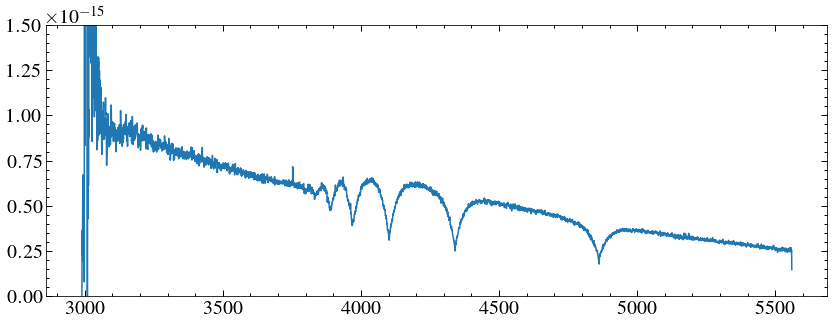

In [5]:

for s in sp[0:1]:
        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
        f = convolve(f,Box1DKernel(smooth))
        plt.plot(w,f)
        
    
#plt.xlim(4800, 4900)
plt.ylim(0, 1.5e-15)

Cross-correlation? Find the best spectrum...

In [6]:
#w, f, e = np.loadtxt(sp[0], unpack=True, delimiter=',')
#f = convolve(f,Box1DKernel(smooth))
#plt.xlim(2900, 3100)
#plt.plot(w,f)
#plt.plot(w,e)
#cut everything over 3100

In [7]:
for i, s in enumerate(sp):
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    print(i, np.median(f[w>3100]/e[w>3100]))

0 31.619976002448297
1 31.576830516451164
2 28.28366827337544
3 28.49310885019313
4 33.79534688408572
5 27.525581022104042
6 31.017271316189046
7 32.35550805975043
8 19.371157142642446
9 32.74539052428673
10 30.570879635594842
11 30.393548814404525
12 30.219876049253706
13 19.837871485188998
14 31.18705634954776
15 30.162135093453415
16 30.482139597132893
17 19.066823890030772
18 18.728737669254713
19 29.682952346007696
20 31.308074681811647
21 30.052238440847646
22 33.17204503395703
23 30.29084835097676
24 28.104290157859495
25 30.80866394317895
26 31.696173721710785
27 34.09249560150426
28 30.657555509351347
29 29.12130765694037
30 29.459508445903456
31 29.770061788375905
32 30.154251293118975
33 49.19814241582646
34 49.232233062192044
35 50.560981926783604
36 51.457209783649326


In [8]:
best = sp[27]

In [9]:
from PyAstronomy.pyasl import crosscorrRV  as ccrv

In [10]:
tw, tf, te = np.loadtxt(sp[27], unpack=True, delimiter=',')
tw, tf, te = tw[tw>3100], tf[tw >3100], te[tw >3100]
#tf = convolve(tf,Box1DKernel(smooth))

In [11]:

"""dates  = []
dvs = []
for s in sp:
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS'] + (150/86400)
    dates.append(date)
    if s == sp[27]:
        dvs.append(0.0)
    else:
        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
        mask = (w >3100)
        w, f, e = w[mask], f[mask], e[mask]
        f = convolve(f,Box1DKernel(smooth))
        rv, cc = ccrv(w, f, tw, tf, -100., 100., 1, skipedge=100)
        dv = rv[np.argmax(cc)]
        dvs.append(dv)
        plt.plot(rv, cc)

#plt.scatter(dates, dvs)"""
    

"dates  = []\ndvs = []\nfor s in sp:\n    date = fits.getheader(s[:-3]+'fits')['MJD-OBS'] + (150/86400)\n    dates.append(date)\n    if s == sp[27]:\n        dvs.append(0.0)\n    else:\n        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')\n        mask = (w >3100)\n        w, f, e = w[mask], f[mask], e[mask]\n        f = convolve(f,Box1DKernel(smooth))\n        rv, cc = ccrv(w, f, tw, tf, -100., 100., 1, skipedge=100)\n        dv = rv[np.argmax(cc)]\n        dvs.append(dv)\n        plt.plot(rv, cc)\n\n#plt.scatter(dates, dvs)"

Ok that didn't work, looks like I need to fit each line.

In [12]:
fitter = fitting.LevMarLSQFitter()

def tiedfunc0(gg_init):
    mean = gg_init.mean_0.value
    return mean

#lines = np.array([486.13615, 434.0462,410.174, 397.0072, 388.9049, 383.5384])
lines = np.array([486.135, 434.0472, 410.1734, 397.0075, 388.9064, 383.5397])
lines *= 10
#plt.figure(figsize=(6, 10))
#for line in lines:
 #   mask = (tw > line-30) & (tw < line+30)
  #  x = np.arange(len(tw[mask]))
  #  plt.plot(x, (tf[mask]-np.max(tf[mask]))*1e16)
  #  gg_init = models.Gaussian1D(-1.0, 0,10)+ models.Gaussian1D(-1.5, 0,0.5)+models.Gaussian1D(-0.5, 0,50)#+models.Const1D(1.0)
   # gg_init.mean_1.tied=tiedfunc0
   # gg_init.mean_2.tied=tiedfunc0
   # gg_fit = fitter(gg_init, x, (tf[mask]-np.max(tf[mask]))*1e16)
   # plt.plot(x, gg_fit(x))

Looks like we need to normalize it first...

In [13]:
#plt.plot(tw, tf)

In [14]:
sp[27]

'/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_13.csv'

In [15]:
cregions = [3700, 3809, 3853, 3856,3920,3930,4022,4035,4185, 4205,4430,4760,4990,5540]

def mask_maker(x, pairs, include=True):
    """
    creates a mask for a spectrum that excudes between pairs from an array
    """
    b = pairs[::2]
    r = pairs[1::2]
    C = np.zeros_like(x,dtype='bool')
    for i in range(len(b)):
        C |= (x>b[i])&(x<r[i])
    if include:
        return ~C
    else:
        return C

#mask = mask_maker(tw, cregions, include=False)

In [16]:
"""tw1, tf1 = tw[mask], tf[mask] 
n_init = models.Polynomial1D(5)
n_fit = fitter(n_init, tw1, tf1)
plt.plot(tw, tf)
plt.plot(tw, n_fit(tw))"""

'tw1, tf1 = tw[mask], tf[mask] \nn_init = models.Polynomial1D(5)\nn_fit = fitter(n_init, tw1, tf1)\nplt.plot(tw, tf)\nplt.plot(tw, n_fit(tw))'

In [17]:
"""plt.figure(figsize=(6, 10))
for line in lines:
    mask = (tw > line-30) & (tw < line+30)
    x = np.arange(len(tw[mask]))
    nf = tf[mask]/n_fit(tw)[mask]
    plt.plot(x, nf)
    mid = len(x)/2
    gg_init = models.Gaussian1D(-0.3, mid,10)+ models.Gaussian1D(-0.5, mid,10)+models.Gaussian1D(-0.2, mid,50)+models.Const1D(1.0)
    gg_init.mean_1.tied=tiedfunc0
    gg_init.mean_2.tied=tiedfunc0
    gg_fit = fitter(gg_init, x, nf)
    plt.plot(x, gg_fit(x))"""

'plt.figure(figsize=(6, 10))\nfor line in lines:\n    mask = (tw > line-30) & (tw < line+30)\n    x = np.arange(len(tw[mask]))\n    nf = tf[mask]/n_fit(tw)[mask]\n    plt.plot(x, nf)\n    mid = len(x)/2\n    gg_init = models.Gaussian1D(-0.3, mid,10)+ models.Gaussian1D(-0.5, mid,10)+models.Gaussian1D(-0.2, mid,50)+models.Const1D(1.0)\n    gg_init.mean_1.tied=tiedfunc0\n    gg_init.mean_2.tied=tiedfunc0\n    gg_fit = fitter(gg_init, x, nf)\n    plt.plot(x, gg_fit(x))'

In [18]:
"""#plt.figure(figsize=(6, 10))
dvs = []
for i, line in enumerate(lines):
    plt.subplot(2,3, i+1)
    mask = (tw > line-30) & (tw < line+30)
    nw = tw[mask]
    nf = tf[mask]/n_fit(tw)[mask]
    plt.plot(nw, nf)
    gg_init = models.Gaussian1D(-0.3, line,10)+ models.Gaussian1D(-0.5, line,5)+models.Const1D(1.0)
    if i < 3:
        gg_init += models.Gaussian1D(-0.2, line,50)
        gg_init.mean_1.tied=tiedfunc0
        gg_init.mean_3.tied=tiedfunc0
    else:
        gg_init.mean_1.tied=tiedfunc0
    gg_fit = fitter(gg_init, nw, nf, maxiter=1000000)
    plt.plot(nw, gg_fit(nw))
    dv = (gg_fit[0].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA)).value
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
   # print (gg_fit)
    dvs.append(dv)
print(dvs)
print(np.mean(dvs))
print(np.median(dvs))
print(np.std(dvs))"""

"#plt.figure(figsize=(6, 10))\ndvs = []\nfor i, line in enumerate(lines):\n    plt.subplot(2,3, i+1)\n    mask = (tw > line-30) & (tw < line+30)\n    nw = tw[mask]\n    nf = tf[mask]/n_fit(tw)[mask]\n    plt.plot(nw, nf)\n    gg_init = models.Gaussian1D(-0.3, line,10)+ models.Gaussian1D(-0.5, line,5)+models.Const1D(1.0)\n    if i < 3:\n        gg_init += models.Gaussian1D(-0.2, line,50)\n        gg_init.mean_1.tied=tiedfunc0\n        gg_init.mean_3.tied=tiedfunc0\n    else:\n        gg_init.mean_1.tied=tiedfunc0\n    gg_fit = fitter(gg_init, nw, nf, maxiter=1000000)\n    plt.plot(nw, gg_fit(nw))\n    dv = (gg_fit[0].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA)).value\n    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))\n   # print (gg_fit)\n    dvs.append(dv)\nprint(dvs)\nprint(np.mean(dvs))\nprint(np.median(dvs))\nprint(np.std(dvs))"

In [19]:
fit_ranges = [[4600, 5500],[4200, 4500], [4025,4220], [3920,4040],[3855,3930], [3800,3865]]
#cregions = [3750, 3809, 3853, 3856,3920,3930,4022,4035,4185, 4205,4430,4760,4990,5500]
nmasks = [[4760,4990],[4205,4430],[4035,4185],[3930,4022],[3856,3920],[3815, 3850]]

In [20]:
def make_plot_spec(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    smooth = 10
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne
    
    
def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error

[45.17691498177666, 75.1635312141787, 112.2478209103637, 162.1615318272061]
98.68744973338129
93.70567606227121
43.67377598746161


(73.9455273935795, 20.389188444887605)

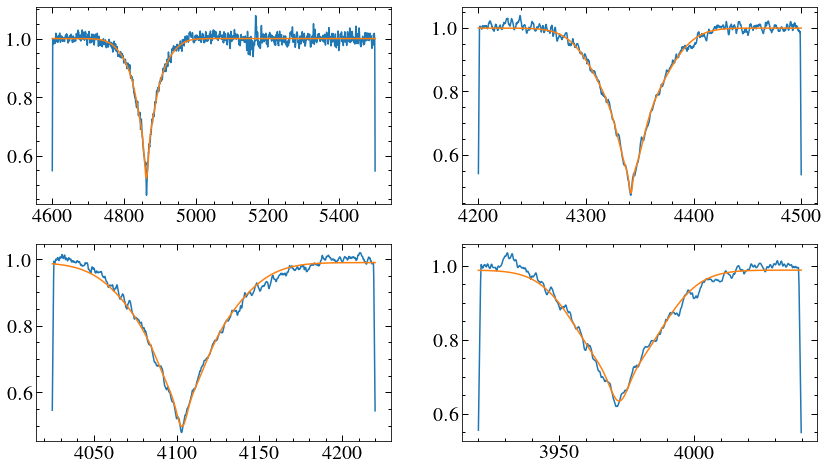

In [21]:
dvs = []
dves = []
plt.figure(figsize=(14, 8))
for i, line in enumerate(lines[0:4]):
    plt.subplot(2,2, i+1)
    
    mask1 = (tw >fit_ranges[i][0]) & (tw < nmasks[i][0]) | (tw >nmasks[i][1]) & (tw < fit_ranges[i][1])
    mask2 = (tw >fit_ranges[i][0]) & (tw < fit_ranges[i][1])
    nw, nf, ne = make_plot_spec(tw, tf, te, mask1, mask2)
    plt.plot(nw, nf)
    gg_init = models.Gaussian1D(-0.3, line,10)+ models.Gaussian1D(-0.5, line,1)+models.Const1D(1.0)
    if i < 3:
        gg_init += models.Gaussian1D(-0.2, line,50)
        gg_init.mean_1.tied=tiedfunc0
        gg_init.mean_3.tied=tiedfunc0
    else:
        gg_init.mean_1.tied=tiedfunc0
    gg_fit = fitter(gg_init, nw, nf, maxiter=100000)
    plt.plot(nw, gg_fit(nw))
    dv = (gg_fit[0].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA)).value
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    #print (fit_e[1]/abs(line-gg_fit[0].mean))
    dvs.append(dv)
    dves.append(dv* fit_e[1]/abs(line-gg_fit[0].mean))
print(dvs)
print(np.mean(dvs))
print(np.median(dvs))
print(np.std(dvs))
dv_average(np.array(dvs), np.array(dves)) 

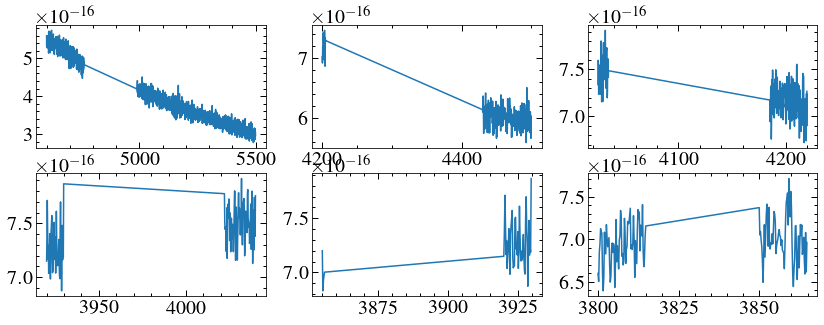

In [22]:
for i, line in enumerate(lines):
    plt.subplot(2,3, i+1)
    
    mask1 = (tw >fit_ranges[i][0]) & (tw < nmasks[i][0]) | (tw >nmasks[i][1]) & (tw < fit_ranges[i][1])
    plt.plot(tw[mask1], tf[mask1])

Maybe working, but with giant error bars? Try for all spectra...

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_9.csv


/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_15.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_32.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_4.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_12.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_6.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_10.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_11.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_3.csv
/ho

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_1.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_2.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_21.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_17.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_19.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_14.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_23.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_7.csv
/ho

<ErrorbarContainer object of 3 artists>

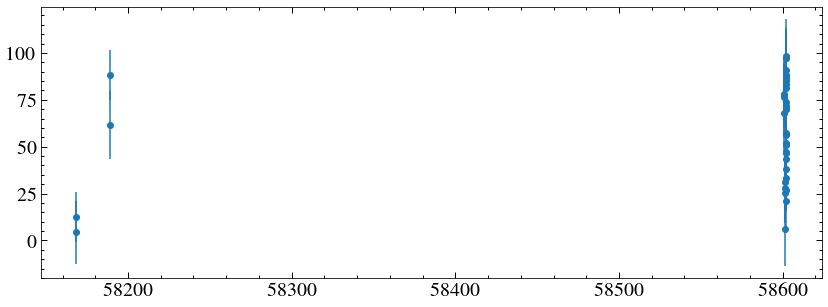

In [23]:
dates = []
dv_all = []
e_all = []
for s in sp:
    print(s)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS'] + (fits.getheader(s[:-3]+'fits')['EXPTIME'])/(2*86400)
    dates.append(date)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    dvs = []
    dves = []
  #  plt.figure(figsize=(14, 8))
    for i, line in enumerate(lines[0:4]):
    #    plt.subplot(2,2, i+1)

        mask1 = (w >fit_ranges[i][0]) & (w < nmasks[i][0]) | (w >nmasks[i][1]) & (w < fit_ranges[i][1])
        mask2 = (w >fit_ranges[i][0]) & (w < fit_ranges[i][1])
        nw, nf, ne = make_plot_spec(w, f, e, mask1, mask2)
     #   plt.plot(nw, nf)
        gg_init = models.Gaussian1D(-0.3, line,10)+ models.Gaussian1D(-0.5, line,1)+models.Const1D(1.0)
        if i < 3:
            gg_init += models.Gaussian1D(-0.2, line,50)
            gg_init.mean_1.tied=tiedfunc0
            gg_init.mean_3.tied=tiedfunc0
        else:
            gg_init.mean_1.tied=tiedfunc0
        gg_fit = fitter(gg_init, nw, nf, maxiter=100000)
     #   plt.plot(nw, gg_fit(nw))
        dv = (gg_fit[0].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA)).value
        if fitter.fit_info['param_cov'] is None:
            dves.append(20)
        else: 
            fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
            dves.append(dv* fit_e[1]/abs(line-gg_fit[0].mean)) 
        #print (fit_e[1]/abs(line-gg_fit[0].mean))
        dvs.append(dv)
        

    dva, dve = dv_average(np.array(dvs), np.array(dves)) 
    dv_all.append(dva)
    e_all.append(dve)

plt.errorbar(dates, dv_all, yerr=e_all, ls='none', marker='o')

In [24]:
period = 4.226953752501198

<ErrorbarContainer object of 3 artists>

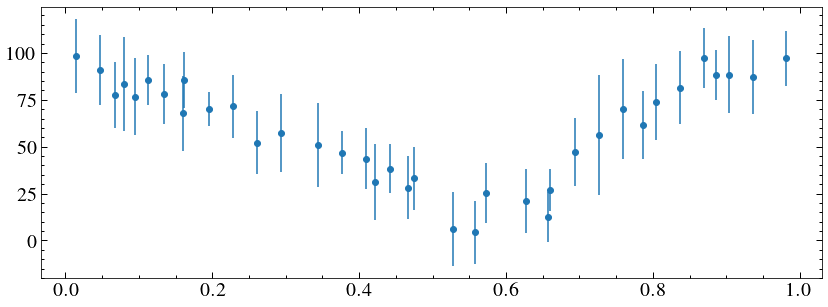

In [25]:
th = np.array(dates) *24
th_fold = th /period %1
plt.errorbar(th_fold, dv_all, yerr=e_all, ls='none', marker='o')

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.86211251)>

    [1]: <Sine1D(amplitude=35.58719567, frequency=1., phase=0.22632587)>
Parameters:
       amplitude_0       amplitude_1    frequency_1      phase_1      
    ----------------- ----------------- ----------- ------------------
    57.86211250568732 35.58719567152517         1.0 0.2263258700415868
[1.70048481 2.36015237 0.01096652]


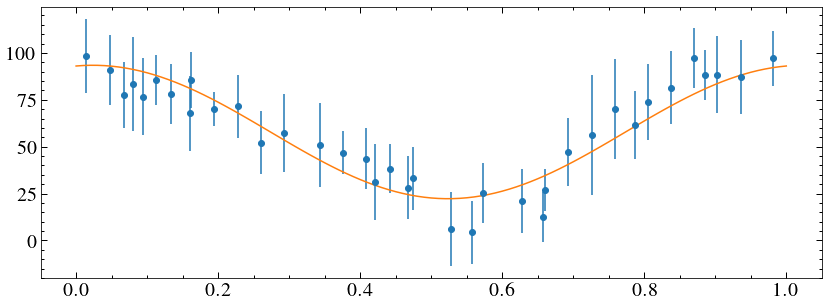

In [26]:
phase_t = np.arange(0,1.01, 0.01 )
abs_mod =  models.Const1D(20, bounds=dict(amplitude=[0, 100])) + models.Sine1D(amplitude=50, frequency=1, phase=0.0, bounds=dict(amplitude=[0, 100]), fixed=dict(frequency=True))
abs_fit = fitter(abs_mod, th_fold, dv_all, weights=1/np.array(e_all), maxiter=100000)
print(abs_fit)
plt.errorbar(th_fold, dv_all, yerr=e_all, ls='none', marker='o')
plt.plot(phase_t, abs_fit(phase_t))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)

Same amplitude as from the h_alpha lines! Add the old spectrum-  updated 20200318 for newly extracted old spectra

In [27]:
args = np.argsort(dates)
dates, dv_all, e_all = np.array(dates)[args], np.array(dv_all)[args], np.array(e_all)[args]




In [28]:
hab_dat = Table([dates, dv_all*u.km/u.s, e_all*u.km/u.s], names=['MJD', 'VELOCITY', 'ERROR'])
ascii.write(hab_dat, 'dv_lists/wd_dvs.ecsv', format='ecsv', overwrite=True)

Also need to measure the Ca 3934 line. No- s/n is too low in individual spectra.

In [29]:
sp = sp[args]

In [30]:

"""
ca_dvs = []
ca_es = []
for s in sp:
    print(s)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS'] + (fits.getheader(s[:-3]+'fits')['EXPTIME'])/(2*86400)
    dates.append(date)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    
  #  plt.figure(figsize=(14, 8))
    for i, line in enumerate(lines[0:4]):
    #    plt.subplot(2,2, i+1)

        mask1 = (w >fit_ranges[i][0]) & (w < nmasks[i][0]) | (w >nmasks[i][1]) & (w < fit_ranges[i][1])
        mask2 = (w >fit_ranges[i][0]) & (w < fit_ranges[i][1])
        nw, nf, ne = make_plot_spec(w, f, e, mask1, mask2)
     #   plt.plot(nw, nf)
        gg_init = models.Gaussian1D(-0.3, line,10)+ models.Gaussian1D(-0.5, line,1)+models.Const1D(1.0)
        if i < 3:
            gg_init += models.Gaussian1D(-0.2, line,50)
            gg_init.mean_1.tied=tiedfunc0
            gg_init.mean_3.tied=tiedfunc0
        else:
            gg_init.mean_1.tied=tiedfunc0
        gg_fit = fitter(gg_init, nw, nf, maxiter=100000)
     #   plt.plot(nw, gg_fit(nw))
        dv = (gg_fit[0].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA)).value
        if fitter.fit_info['param_cov'] is None:
            dves.append(20)
        else: 
            fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
            dves.append(dv* fit_e[1]/abs(line-gg_fit[0].mean)) 
        #print (fit_e[1]/abs(line-gg_fit[0].mean))
        dvs.append(dv)
        

    dva, dve = dv_average(np.array(dvs), np.array(dves)) 
    dv_all.append(dva)
    e_all.append(dve)

plt.errorbar(dates, dv_all, yerr=e_all, ls='none', marker='o')"""

"\nca_dvs = []\nca_es = []\nfor s in sp:\n    print(s)\n    date = fits.getheader(s[:-3]+'fits')['MJD-OBS'] + (fits.getheader(s[:-3]+'fits')['EXPTIME'])/(2*86400)\n    dates.append(date)\n    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')\n    \n  #  plt.figure(figsize=(14, 8))\n    for i, line in enumerate(lines[0:4]):\n    #    plt.subplot(2,2, i+1)\n\n        mask1 = (w >fit_ranges[i][0]) & (w < nmasks[i][0]) | (w >nmasks[i][1]) & (w < fit_ranges[i][1])\n        mask2 = (w >fit_ranges[i][0]) & (w < fit_ranges[i][1])\n        nw, nf, ne = make_plot_spec(w, f, e, mask1, mask2)\n     #   plt.plot(nw, nf)\n        gg_init = models.Gaussian1D(-0.3, line,10)+ models.Gaussian1D(-0.5, line,1)+models.Const1D(1.0)\n        if i < 3:\n            gg_init += models.Gaussian1D(-0.2, line,50)\n            gg_init.mean_1.tied=tiedfunc0\n            gg_init.mean_3.tied=tiedfunc0\n        else:\n            gg_init.mean_1.tied=tiedfunc0\n        gg_fit = fitter(gg_init, nw, nf, maxiter=100000)\

In [31]:
"""old_path = '/home/david/work/1144_lt/spectra/SDSSJ1144_old/'
old_spec = glob.glob(old_path+'*UVB*.csv')[0]
old_date = fits.getheader(old_spec[:-3]+'fits')['MJD-OBS'] +(1400/86400)"""

"old_path = '/home/david/work/1144_lt/spectra/SDSSJ1144_old/'\nold_spec = glob.glob(old_path+'*UVB*.csv')[0]\nold_date = fits.getheader(old_spec[:-3]+'fits')['MJD-OBS'] +(1400/86400)"

In [32]:
"""tw, tf, te = np.loadtxt(old_spec, unpack=True, delimiter=',')

dvs = []
dves = []
plt.figure(figsize=(14, 8))
for i, line in enumerate(lines[0:4]):
    plt.subplot(2,2, i+1)
    
    mask1 = (tw >fit_ranges[i][0]) & (tw < nmasks[i][0]) | (tw >nmasks[i][1]) & (tw < fit_ranges[i][1])
    mask2 = (tw >fit_ranges[i][0]) & (tw < fit_ranges[i][1])
    nw, nf, ne = make_plot_spec(tw, tf, te, mask1, mask2)
    plt.plot(nw, nf)
    gg_init = models.Gaussian1D(-0.3, line,10)+ models.Gaussian1D(-0.5, line,1)+models.Const1D(1.0)
    if i < 3:
        gg_init += models.Gaussian1D(-0.2, line,50)
        gg_init.mean_1.tied=tiedfunc0
        gg_init.mean_3.tied=tiedfunc0
    else:
        gg_init.mean_1.tied=tiedfunc0
    gg_fit = fitter(gg_init, nw, nf, maxiter=100000)
    plt.plot(nw, gg_fit(nw))
    dv = (gg_fit[0].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA)).value
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    #print (fit_e[1]/abs(line-gg_fit[0].mean))
    dvs.append(dv)
    dves.append(dv* fit_e[1]/abs(line-gg_fit[0].mean))

old_dv, old_e = dv_average(np.array(dvs), np.array(dves)) """

"tw, tf, te = np.loadtxt(old_spec, unpack=True, delimiter=',')\n\ndvs = []\ndves = []\nplt.figure(figsize=(14, 8))\nfor i, line in enumerate(lines[0:4]):\n    plt.subplot(2,2, i+1)\n    \n    mask1 = (tw >fit_ranges[i][0]) & (tw < nmasks[i][0]) | (tw >nmasks[i][1]) & (tw < fit_ranges[i][1])\n    mask2 = (tw >fit_ranges[i][0]) & (tw < fit_ranges[i][1])\n    nw, nf, ne = make_plot_spec(tw, tf, te, mask1, mask2)\n    plt.plot(nw, nf)\n    gg_init = models.Gaussian1D(-0.3, line,10)+ models.Gaussian1D(-0.5, line,1)+models.Const1D(1.0)\n    if i < 3:\n        gg_init += models.Gaussian1D(-0.2, line,50)\n        gg_init.mean_1.tied=tiedfunc0\n        gg_init.mean_3.tied=tiedfunc0\n    else:\n        gg_init.mean_1.tied=tiedfunc0\n    gg_fit = fitter(gg_init, nw, nf, maxiter=100000)\n    plt.plot(nw, gg_fit(nw))\n    dv = (gg_fit[0].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA)).value\n    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))\n    #print (fit_e[1]/abs(li

In [33]:
"""oldh = old_date *24
oldh_fold = oldh/period % 1
plt.errorbar(th_fold, dv_all, yerr=e_all, ls='none', marker='o')
plt.errorbar(oldh_fold, old_dv, yerr=old_e, ls='none', marker='o')"""

"oldh = old_date *24\noldh_fold = oldh/period % 1\nplt.errorbar(th_fold, dv_all, yerr=e_all, ls='none', marker='o')\nplt.errorbar(oldh_fold, old_dv, yerr=old_e, ls='none', marker='o')"

In [34]:
"""all_dates = np.append(old_date, dates)
all_dvs = np.append(old_dv, dv_all)
all_dves = np.append(old_e, e_all)
args = np.argsort(all_dates)
all_dates, all_dvs, all_dves = all_dates[args], all_dvs[args], all_dves[args]"""

'all_dates = np.append(old_date, dates)\nall_dvs = np.append(old_dv, dv_all)\nall_dves = np.append(old_e, e_all)\nargs = np.argsort(all_dates)\nall_dates, all_dvs, all_dves = all_dates[args], all_dvs[args], all_dves[args]'

In [35]:
"""plt.errorbar(all_dates, all_dvs, yerr=all_dves)
plt.xlim(5600, 58605)"""

'plt.errorbar(all_dates, all_dvs, yerr=all_dves)\nplt.xlim(5600, 58605)'

In [36]:
"""th = np.array(all_dates) *24
th_fold = th /period %1
plt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o')"""

"th = np.array(all_dates) *24\nth_fold = th /period %1\nplt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o')"

Phaseing looks out?

In [37]:
"""hab_dvs = Table.read('dv_lists/ha_ab_dvs.ecsv')
ta, dva, dvea = np.array(hab_dvs['MJD']), np.array(hab_dvs['VELOCITY']), np.array(hab_dvs['ERROR'])"""

"hab_dvs = Table.read('dv_lists/ha_ab_dvs.ecsv')\nta, dva, dvea = np.array(hab_dvs['MJD']), np.array(hab_dvs['VELOCITY']), np.array(hab_dvs['ERROR'])"

In [38]:
"""ta_fold = ta*24/period %1
plt.errorbar(ta_fold, dva, yerr=dvea, marker='o', ls='none')
plt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o')"""

"ta_fold = ta*24/period %1\nplt.errorbar(ta_fold, dva, yerr=dvea, marker='o', ls='none')\nplt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o')"

Timings off somewhere, but looks good!

In [39]:
"""linepath = 'dv_lists/'
ca_dvs = Table.read(linepath+'ca_dvs.ecsv')
tc, dvc, dvec = np.array(ca_dvs['MJD']), np.array(ca_dvs['VELOCITY']), np.array(ca_dvs['ERROR'])
plt.errorbar(tc, dvc, yerr=dvec, ls='none', marker='o')
plt.errorbar(all_dates, all_dvs, yerr=all_dves, marker='o', ls='none')
plt.xlim(58602, 58602.5)"""

"linepath = 'dv_lists/'\nca_dvs = Table.read(linepath+'ca_dvs.ecsv')\ntc, dvc, dvec = np.array(ca_dvs['MJD']), np.array(ca_dvs['VELOCITY']), np.array(ca_dvs['ERROR'])\nplt.errorbar(tc, dvc, yerr=dvec, ls='none', marker='o')\nplt.errorbar(all_dates, all_dvs, yerr=all_dves, marker='o', ls='none')\nplt.xlim(58602, 58602.5)"

Oooh can I get a period out of the uv lines?

In [40]:
"""from astropy.timeseries import LombScargle"""

'from astropy.timeseries import LombScargle'

In [41]:
"""frequency, power = LombScargle(tc*24, dvc, dvec, normalization='model').autopower(minimum_frequency = 1/5, maximum_frequency = 1/3)
period = 1/frequency[np.argmax(power)]
print(period)
plt.plot(1/frequency, power)

#frequency, power = LombScargle(th, all_dvs, all_dves, normalization='model').autopower(minimum_frequency = 1/5, maximum_frequency = 1/3)
#period = 1/frequency[np.argmax(power)]
#print(period)
#plt.plot(1/frequency, power)

#plt.ylim(0, 500)"""

"frequency, power = LombScargle(tc*24, dvc, dvec, normalization='model').autopower(minimum_frequency = 1/5, maximum_frequency = 1/3)\nperiod = 1/frequency[np.argmax(power)]\nprint(period)\nplt.plot(1/frequency, power)\n\n#frequency, power = LombScargle(th, all_dvs, all_dves, normalization='model').autopower(minimum_frequency = 1/5, maximum_frequency = 1/3)\n#period = 1/frequency[np.argmax(power)]\n#print(period)\n#plt.plot(1/frequency, power)\n\n#plt.ylim(0, 500)"

In [42]:
"""th_fold = th /period %1
tc_fold = tc*24 /period %1
plt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o')
plt.errorbar(tc_fold, dvc, yerr=dvec, ls='none', marker='o')"""

"th_fold = th /period %1\ntc_fold = tc*24 /period %1\nplt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o')\nplt.errorbar(tc_fold, dvc, yerr=dvec, ls='none', marker='o')"

In [43]:
"""fitter = fitting.LevMarLSQFitter()
sine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[100, 200]), fixed=dict(frequency=True))
sine_fit = fitter(sine_mod, tc_fold, dvc, weights=1/dvec, maxiter=100000)
print(sine_fit)
plt.errorbar(tc_fold, dvc, yerr=dvec, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)"""

"fitter = fitting.LevMarLSQFitter()\nsine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[100, 200]), fixed=dict(frequency=True))\nsine_fit = fitter(sine_mod, tc_fold, dvc, weights=1/dvec, maxiter=100000)\nprint(sine_fit)\nplt.errorbar(tc_fold, dvc, yerr=dvec, marker='o', ls='none')\nphase_t = np.arange(0,1.01, 0.01 )\nplt.plot(phase_t, sine_fit(phase_t))\nfit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))\nprint(fit_e)"

In [44]:
"""errs = np.array(ca_dvs['ERROR'])

iterate = True
i = 0
while iterate and i < 10:
    i +=1
    sine_fit = fitter(sine_mod, tc_fold, dvc, weights=1/errs, maxiter=100000)
    calc_dvs = sine_fit(tc_fold)
    rcs = chisq(dvc, f_exp=calc_dvs, axis = 0)[0]/3
    print (rcs)
    if rcs <= 1.0:
        iterate= False
    else:
        errs += 1.0

print(sine_fit)
plt.errorbar(tc_fold, dvc, yerr=errs, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)"""

"errs = np.array(ca_dvs['ERROR'])\n\niterate = True\ni = 0\nwhile iterate and i < 10:\n    i +=1\n    sine_fit = fitter(sine_mod, tc_fold, dvc, weights=1/errs, maxiter=100000)\n    calc_dvs = sine_fit(tc_fold)\n    rcs = chisq(dvc, f_exp=calc_dvs, axis = 0)[0]/3\n    print (rcs)\n    if rcs <= 1.0:\n        iterate= False\n    else:\n        errs += 1.0\n\nprint(sine_fit)\nplt.errorbar(tc_fold, dvc, yerr=errs, marker='o', ls='none')\nphase_t = np.arange(0,1.01, 0.01 )\nplt.plot(phase_t, sine_fit(phase_t))\nfit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))\nprint(fit_e)"

In [45]:
"""abs_mod =  models.Const1D(20, bounds=dict(amplitude=[0, 100])) + models.Sine1D(amplitude=50, frequency=1, phase=0.5, bounds=dict(amplitude=[0, 100]), fixed=dict(frequency=True))
abs_fit = fitter(abs_mod, th_fold, all_dvs, weights=1/all_dves, maxiter=100000)
print(abs_fit)
plt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o')
plt.plot(phase_t, abs_fit(phase_t))
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fit_e)"""

"abs_mod =  models.Const1D(20, bounds=dict(amplitude=[0, 100])) + models.Sine1D(amplitude=50, frequency=1, phase=0.5, bounds=dict(amplitude=[0, 100]), fixed=dict(frequency=True))\nabs_fit = fitter(abs_mod, th_fold, all_dvs, weights=1/all_dves, maxiter=100000)\nprint(abs_fit)\nplt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o')\nplt.plot(phase_t, abs_fit(phase_t))\nfit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))\nprint(fit_e)"

In [46]:
"""ep = 0.2/period
m1 = 0.49 #Msun, from G+2015
m1e = 0.03
v1 = 33
v1e = v1*((2.1/v1)**2+ep**2)**0.5
v2 = 196.6
v2e = v2*((1.5/v2)**2+ep**2)**0.5
v1v2 = v1/v2
v1v2e = ((v1e/v1)**2+(v2e/v2)**2)**0.5
print(v1v2, v1v2e)
m2 = m1 * v1v2
m2e = m2 * (v1v2e**2+(m1e/m1)**2)**0.5
print (m2)
print(m2e)"""

'ep = 0.2/period\nm1 = 0.49 #Msun, from G+2015\nm1e = 0.03\nv1 = 33\nv1e = v1*((2.1/v1)**2+ep**2)**0.5\nv2 = 196.6\nv2e = v2*((1.5/v2)**2+ep**2)**0.5\nv1v2 = v1/v2\nv1v2e = ((v1e/v1)**2+(v2e/v2)**2)**0.5\nprint(v1v2, v1v2e)\nm2 = m1 * v1v2\nm2e = m2 * (v1v2e**2+(m1e/m1)**2)**0.5\nprint (m2)\nprint(m2e)'

In [47]:
"""plt.errorbar(tc_fold, dvc, yerr=errs, marker='o', ls='none')
plt.plot(phase_t, sine_fit(phase_t))
plt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o')
plt.plot(phase_t, abs_fit(phase_t))"""

"plt.errorbar(tc_fold, dvc, yerr=errs, marker='o', ls='none')\nplt.plot(phase_t, sine_fit(phase_t))\nplt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o')\nplt.plot(phase_t, abs_fit(phase_t))"

In [48]:
"""plt.figure(figsize=(10,6))
plt.errorbar(tc_fold, dvc, yerr=errs, marker='o', ls='none', label='Companion')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
plt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o', label='White Dwarf')
plt.plot(phase_t, abs_fit(phase_t))
plt.xlabel('Phase')
plt.ylabel('Radial Velocity (km\,s$^{-1}$)')
plt.legend()
plt.tight_layout()
#plt.savefig('binary_rvs_label.png', dip=150)"""

"plt.figure(figsize=(10,6))\nplt.errorbar(tc_fold, dvc, yerr=errs, marker='o', ls='none', label='Companion')\nphase_t = np.arange(0,1.01, 0.01 )\nplt.plot(phase_t, sine_fit(phase_t))\nplt.errorbar(th_fold, all_dvs, yerr=all_dves, ls='none', marker='o', label='White Dwarf')\nplt.plot(phase_t, abs_fit(phase_t))\nplt.xlabel('Phase')\nplt.ylabel('Radial Velocity (km\\,s$^{-1}$)')\nplt.legend()\nplt.tight_layout()\n#plt.savefig('binary_rvs_label.png', dip=150)"

In [49]:
"""gr = 59.3-26.3
gre = (1.4**2+1.5**2)**0.5
print (gr, gre)"""

'gr = 59.3-26.3\ngre = (1.4**2+1.5**2)**0.5\nprint (gr, gre)'

In [50]:
#hab_dat = Table([all_dates*u.d, all_dvs*u.km/u.s, all_dves*u.km/u.s], names=['MJD', 'VELOCITY', 'ERROR'])
#hab_dat.write('dv_lists/wd_dvs.ecsv', format='ascii.ecsv', overwrite=True)

Coadding spectra

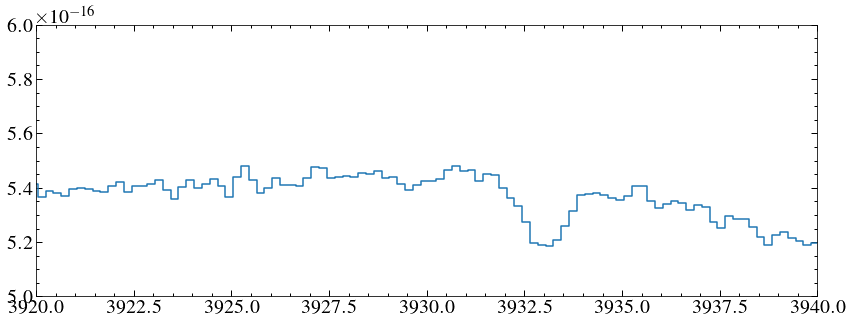

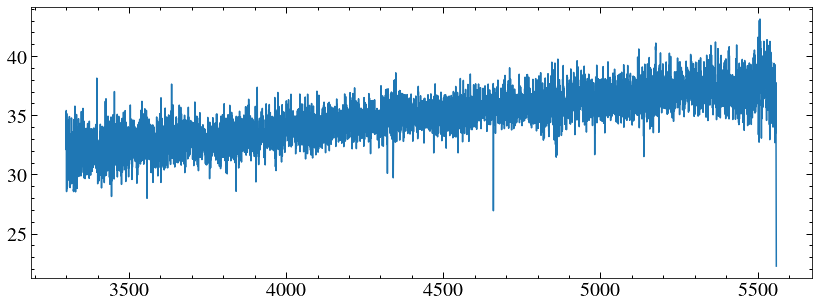

In [51]:
import astropy.constants as const
from scipy.interpolate import interp1d

def spectra_adder(f_array, e_array):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    error = (var * rcs)**0.5 
    return flux, error#var**0.5

f_full = []
e_full = []

for i, s in enumerate(sp):
   # print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    mask = (w > 3300)
    w, f, e = w[mask], f[mask], e[mask]
    dv = dv_all[i]
   # print(dv)
    shift = 1+(dv*1e3/const.c.value)
    if i == 0:
        w_full = w/shift
        f_full.append(f)
        e_full.append(e)
    else:
        f_full.append(interp1d(w/shift, f, fill_value='extrapolate')(w_full))
        e_full.append(interp1d(w/shift, e, fill_value='extrapolate')(w_full))

f_new, e_new = spectra_adder(np.array(f_full), np.array(e_full))
plt.step(w_full, f_new, where='mid')
plt.step(w_full, e_new, where='mid')
plt.xlim(3920, 3940)
plt.ylim(5e-16, 6e-16)
plt.show()
plt.plot(w_full, f_new/e_new)


In [52]:
savdat = Table([w_full, f_new,e_new])
ascii.write(savdat, 'spectra/sdss1144_xsuvb_coadd_wdshift.dat', format='basic')